In [ ]:
%reload_ext autoreload
%autoreload 2
%pylab inline

import os
import pickle
import random
from collections import namedtuple
from itertools import count

import gym
import numpy as np
import pycuber
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
from gym import spaces
from gym.utils import seeding
from tensorboardX import SummaryWriter
from torch.distributions import Categorical

import cube
import dqn
import solver

In [ ]:
ValueTransition = namedtuple('Transition', ('state', 'value'))

class ValueMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = ValueTransition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
max_steps = 10
value_memory = ValueMemory(100000)

while len(value_memory) < value_memory.capacity:    
    shuffle_cube = pycuber.Cube()
    for value in range(0, max_steps + 1):
        shuffle_cube.perform_step(
            cube.ACTIONS[np.random.randint(cube.N_ACTION)])
        observation = cube.get_observation(cube.get_state(shuffle_cube))
        value_memory.push(
            observation.view(1, -1),
            torch.FloatTensor([1 / (value + 1)]))

In [ ]:
def optimize_model():
    transitions = value_memory.sample(BATCH_SIZE)
    batch = ValueTransition(*zip(*transitions))
    
    state_batch = torch.cat(batch.state)
    value_batch = torch.cat(batch.value)
    
    state_values = value_net(state_batch)
    loss = F.l1_loss(state_values, value_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    writer.add_scalar('value_network/train_loss', loss.detach(), steps_done)

In [ ]:
def train(num_steps):
    global steps_done
    
    for i_steps in range(num_steps):
        optimize_model()
        steps_done += 1

In [ ]:
BATCH_SIZE = 512

value_net = dqn.ValueNetwork(cube.N_SPACE)
optimizer = optim.Adam(value_net.parameters())

steps_done = 0

writer = SummaryWriter(log_dir='logs/value_net_test_ratio')

In [ ]:
train(10000)

In [24]:
for i in range(16):
    shuffle_cube.perform_step(
        cube.ACTIONS[np.random.randint(cube.N_ACTION)])
    observation = cube.get_observation(cube.get_state(shuffle_cube))
    print('{} {}'.format(i, 1 / float(value_net(observation).detach())))

0 5.933557181326069
1 5.9232645781105235
2 5.934468073064788
3 5.927142692612876
4 5.94275974355464
5 5.939015692594672
6 5.9441035770716875
7 5.941136163478472
8 5.939638059182667
9 5.941136163478472
10 5.939265885105873
11 5.9307795346729355
12 5.935516259353284
13 5.943061829434869
14 5.947660587116977
15 5.941913119454486


In [ ]:
def get_value(shuffle_cube):
    return np.mean(cube.get_state(shuffle_cube) == cube.FINAL_STATE)

In [ ]:
shuffle_cube = pycuber.Cube()
shuffle_cube

In [31]:
for i in range(20):
    shuffle_cube.perform_step(
        cube.ACTIONS[np.random.randint(cube.N_ACTION)])
    print('{} {}'.format(i, get_value(shuffle_cube)))

0 0.7777777777777778
1 1.0
2 0.7777777777777778
3 0.5925925925925926
4 0.4444444444444444
5 0.3888888888888889
6 0.48148148148148145
7 0.4444444444444444
8 0.42592592592592593
9 0.37037037037037035
10 0.3333333333333333
11 0.37037037037037035
12 0.3333333333333333
13 0.35185185185185186
14 0.25925925925925924
15 0.25925925925925924


In [32]:
values = []
for _ in range(100):
    shuffle_cube = pycuber.Cube()
    cube_values = []
    for _ in range(20):
        shuffle_cube.perform_step(
            cube.ACTIONS[np.random.randint(cube.N_ACTION)])
        cube_values.append(get_value(shuffle_cube))
    values.append(cube_values)

In [33]:
values = np.array(values)

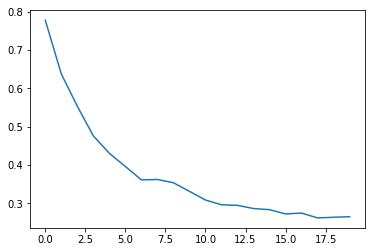

In [41]:
plt.plot(values.mean(axis=0))

In [45]:
values = []
for _ in range(100):
    shuffle_cube = pycuber.Cube()
    cube_values = []
    for _ in range(20):
        shuffle_cube.perform_step(
            cube.ACTIONS[np.random.randint(cube.N_ACTION)])
        observation = cube.get_observation(cube.get_state(shuffle_cube))
        cube_values.append(float(value_net(observation).detach()))
    values.append(cube_values)

In [46]:
values = np.array(values)

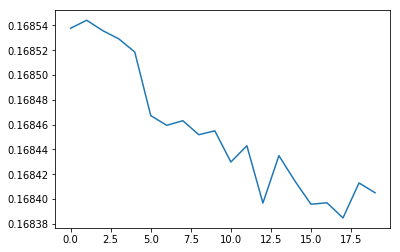

In [47]:
plt.plot(values.mean(axis=0))